In [33]:

importlib.reload(testappstf)

<module 'testappstf' from 'C:\\Users\\lan66\\4th year project\\2nd term\\testappstf.py'>

In [1]:
import numpy as np 
import obspy
import matplotlib.pyplot as plt
import os,glob
import pandas as pd
import pystp
from obspy.clients.fdsn import Client
from obspy import UTCDateTime
import importlib
import edphscoh as phscoh
import testappstf as testappstf

In [2]:
#generation of synthetic earthquakes defining diameters

rad = np.array([10.]) #diameter of foreshocks is 10m
rad2 = 5 #diameter of mainshock is 5x10 = 50m
seqs,seqs2=testappstf.appstfcalc(N=10, eqtyp='het', rad=rad, secrad=rad2) 


In [3]:
#displays azimuthal strike of the 10 stations arranged in a semi circle 
seqs[0].ststrike

array([  0.,  20.,  40.,  60.,  80., 100., 120., 140., 160., 180.])

In [5]:
#Defines a function to project earthquake positions onto the vectors defined by station azimuths
def project_earthquake_to_stations(xyz, phi_list_deg, theta_deg):
    """
    Projects the earthquake location onto multiple station direction vectors 
    defined by varying phi angles.

    Parameters:
    xyz : list or np.ndarray
        Earthquake location in local fault-coordinates [x, y, z]
    phi_list_deg : list or np.ndarray
        List of azimuthal angles (phi) in degrees
    theta_deg : float
        Polar angle (theta) in degrees, angle from vertical

    Returns:
    np.ndarray
        Array of scalar projections (change in distance) for each phi angle
    """
    # Convert angles to radians
    theta = np.radians(theta_deg)
    phi_list = np.radians(phi_list_deg)

    # Location vector
    location = np.array(xyz)

    # Calculate direction vectors for each phi
    sin_theta = np.sin(theta)
    cos_theta = np.cos(theta)
    
    # Broadcasting over phi array
    n_vectors = np.array([
        np.sin(phi_list) * sin_theta,
        np.cos(phi_list) * sin_theta,
        np.full_like(phi_list, cos_theta)
    ]).T  

    # Dot product for each direction vector with the xyz location
    delta_d = np.dot(n_vectors, location)

    return delta_d


In [9]:
# A random location for the earthquake is created , can specify and create multiple locations depending on aims
xz1 = np.random.normal(0, 2 , 2)
print(xz1)
y1 = np.random.normal(0, 0.1 , 1)
print(y1)
xyz1 = np.insert(xz1, 1, y1)
print(xyz1)

[-0.49062412  1.79817645]
[0.0269222]
[-0.49062412  0.0269222   1.79817645]


In [33]:
#That random location is projected to station and time shift calculated
xyz = xyz1
phi_angles = [  0.,  20.,  40.,  60.,  80., 100., 120., 140., 160., 180.]
theta = 90

change_in_distances_f1 = project_earthquake_to_stations(xyz, phi_angles, theta)
print("station angle/ phi:", phi_angles)
print("Change in distances:", change_in_distances_f1)

time_shifts_f1 = change_in_distances_f1/ 6000.
print(time_shifts_f1)

station angle/ phi: [0.0, 20.0, 40.0, 60.0, 80.0, 100.0, 120.0, 140.0, 160.0, 180.0]
Change in distances: [ 0.0269222  -0.14250474 -0.2947435  -0.41143185 -0.47849544 -0.48784542
 -0.43835405 -0.3359907  -0.19310192 -0.0269222 ]
[ 4.48703300e-06 -2.37507900e-05 -4.91239172e-05 -6.85719750e-05
 -7.97492406e-05 -8.13075708e-05 -7.30590080e-05 -5.59984506e-05
 -3.21836536e-05 -4.48703300e-06]


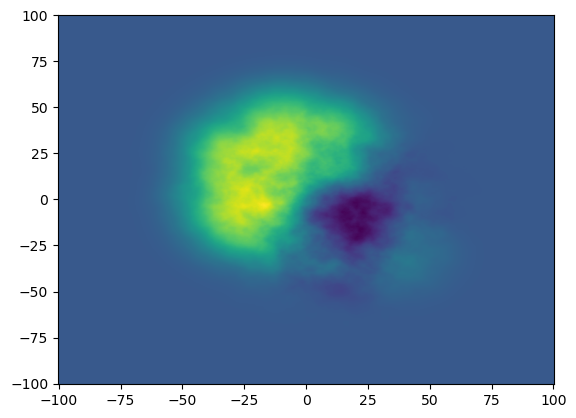

In [28]:
#mainshock rupture diameter across x and y axis (both equal 50m)
#Plot slip distribution using color map  
seqs2[0].a
seqs2[0].b
plt.pcolormesh(seqs2[0].x, seqs2[0].y, seqs2[0].slip)

In [ ]:
# pick a set of times
# these will be the new tmom
t=np.arange(-5,20,np.median(np.diff(seqs[0].tmom)))

# start with no foreshocks, creates a copy
tmomc= seqs[0].tmom.copy()
amomc=seqs[0].amom.copy()
amom=np.zeros([t.size,seqs[0].amom.shape[1]],dtype=float)

(1.7, 26.0)

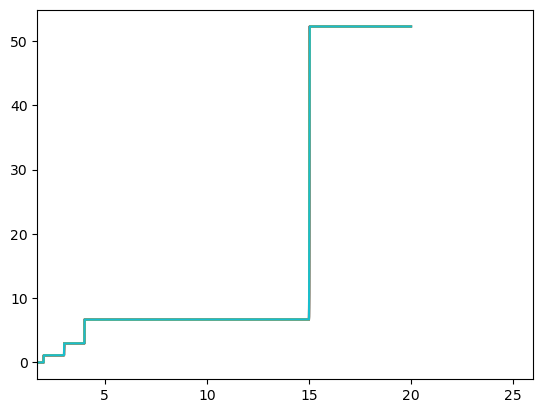

In [12]:
# add a foreshock at specified time 2 and time 4
for x in range(amom.shape[1]): 
# pick location
    shift_f1 = time_shifts_f1[x]
    #shift_f2 = time_shifts_f2[x] etc if more locations generated

    # create a new apparent moment function
    #add foreshocks
    amom[:, x] =amom[:, x]+ np.interp(t, tmomc + 2 + shift_f1, amomc[:, x]*3)
    amom[:, x] =amom[:, x]+ np.interp(t, tmomc + 3 + shift_f1, amomc[:, x] * 5)
    amom[:, x] =amom[:, x]+ np.interp(t, tmomc + 4 + shift_f1, amomc[:, x] * 10)
    #add mainshock
    amom[:, x] =amom[:, x]+ np.interp(t, seqs2[0].tmom + 15, seqs2[0].amom[:, x])
    #add noise 
amom =amom+ np.random.normal(0, 0.0001, amom.shape)

#plots new apparent moment function
plt.plot(t, amom[:, :])  
plt.xlim([1.7, 26])



In [13]:

# change tmom and amom
seqs[0].tmom = t
seqs[0].amom = amom

In [14]:
#convolves to create Green's functions
seqs[0].calcfakeobs()

In [15]:
# grabs some waveforms from the synthetics
st1=seqs[0].obswaveforms()
st2=seqs2[0].obswaveforms()

print('Waveforms for first and second earthquake')
print(st1)
print(st2)

Waveforms for first and second earthquake
10 Trace(s) in Stream:
.S1..  | 1970-01-01T00:00:00.000000Z - 1970-01-01T00:00:30.999967Z | 30000.0 Hz, 930000 samples
.S2..  | 1970-01-01T00:00:00.000000Z - 1970-01-01T00:00:30.999967Z | 30000.0 Hz, 930000 samples
.S3..  | 1970-01-01T00:00:00.000000Z - 1970-01-01T00:00:30.999967Z | 30000.0 Hz, 930000 samples
.S4..  | 1970-01-01T00:00:00.000000Z - 1970-01-01T00:00:30.999967Z | 30000.0 Hz, 930000 samples
.S5..  | 1970-01-01T00:00:00.000000Z - 1970-01-01T00:00:30.999967Z | 30000.0 Hz, 930000 samples
.S6..  | 1970-01-01T00:00:00.000000Z - 1970-01-01T00:00:30.999967Z | 30000.0 Hz, 930000 samples
.S7..  | 1970-01-01T00:00:00.000000Z - 1970-01-01T00:00:30.999967Z | 30000.0 Hz, 930000 samples
.S8..  | 1970-01-01T00:00:00.000000Z - 1970-01-01T00:00:30.999967Z | 30000.0 Hz, 930000 samples
.S9..  | 1970-01-01T00:00:00.000000Z - 1970-01-01T00:00:30.999967Z | 30000.0 Hz, 930000 samples
.S10.. | 1970-01-01T00:00:00.000000Z - 1970-01-01T00:00:30.999967Z | 30

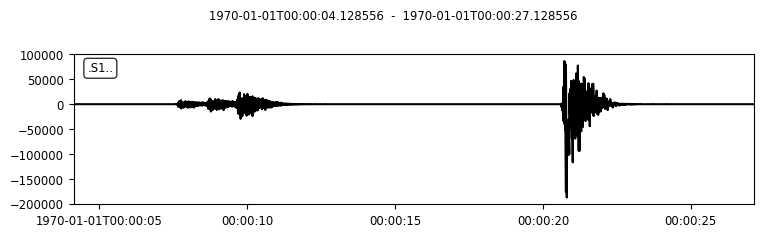

t0: 20.12855550709912
t1: 6.128555507099119


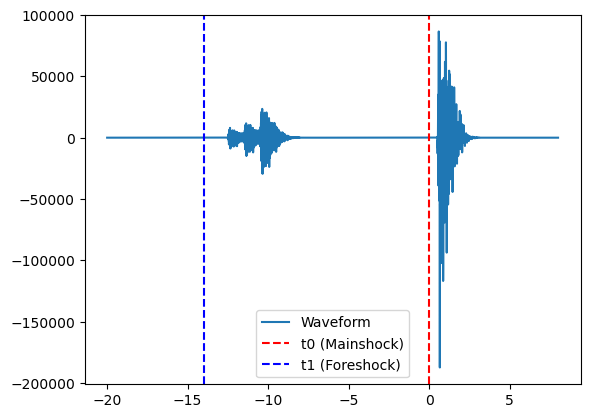

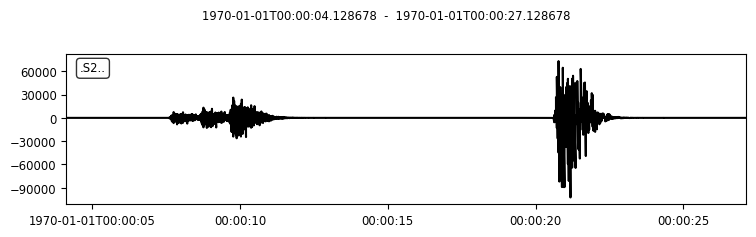

t0: 20.128678439115514
t1: 6.1286784391155145


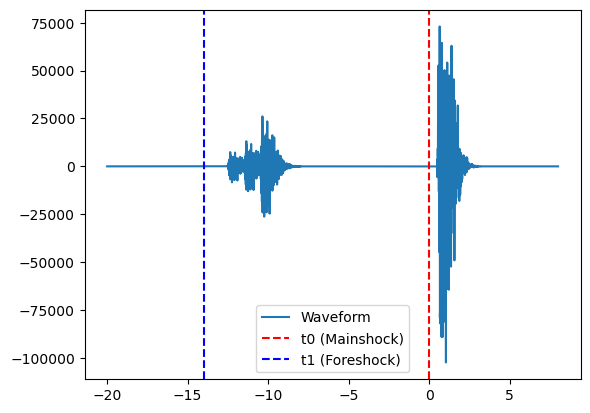

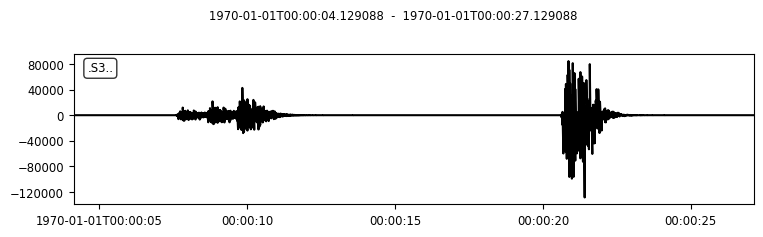

t0: 20.129088342192823
t1: 6.129088342192823


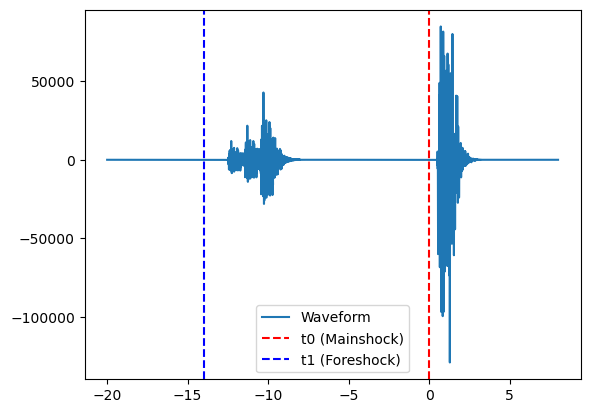

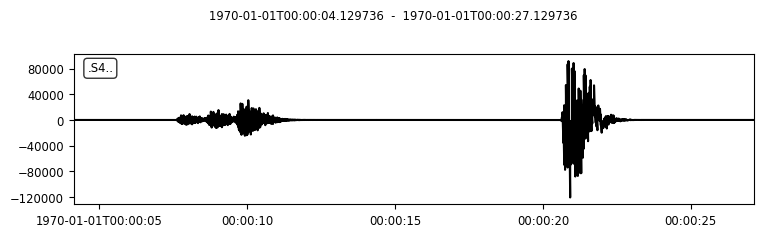

t0: 20.129735775970417
t1: 6.129735775970417


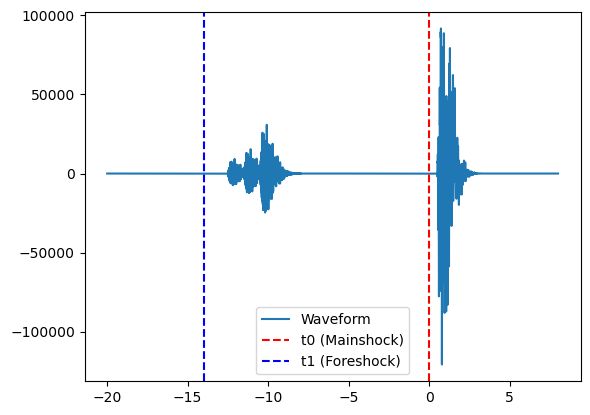

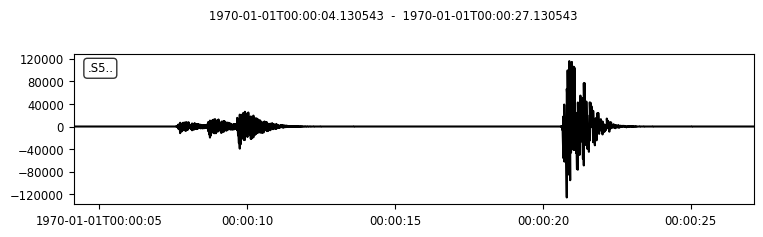

t0: 20.130542650379596
t1: 6.130542650379596


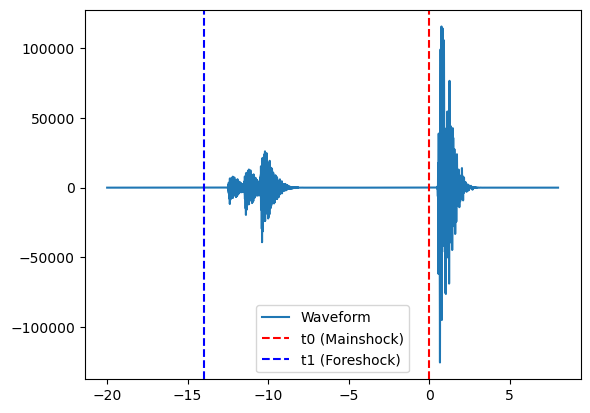

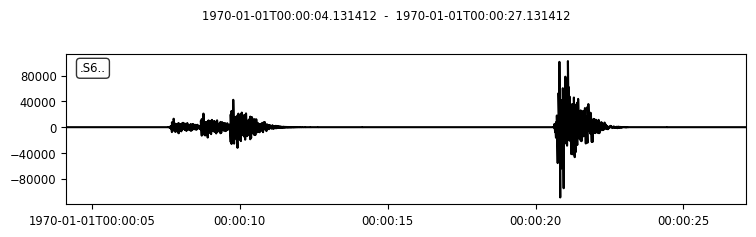

t0: 20.131411644458446
t1: 6.131411644458446


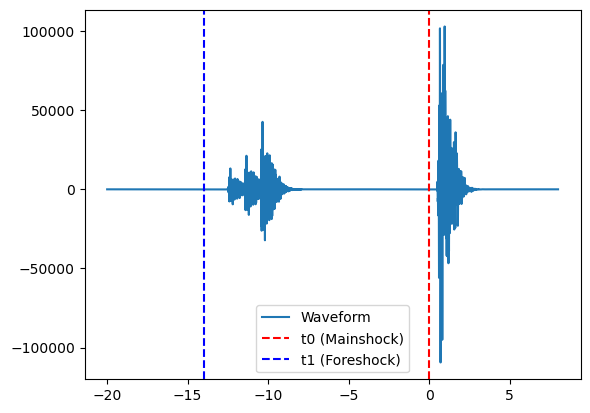

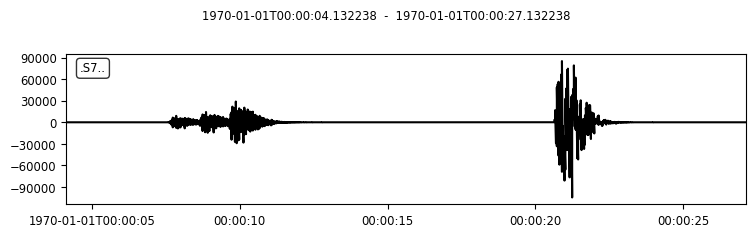

t0: 20.13223794469603
t1: 6.13223794469603


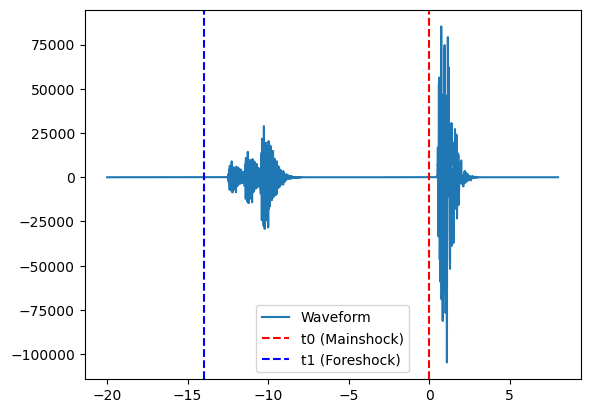

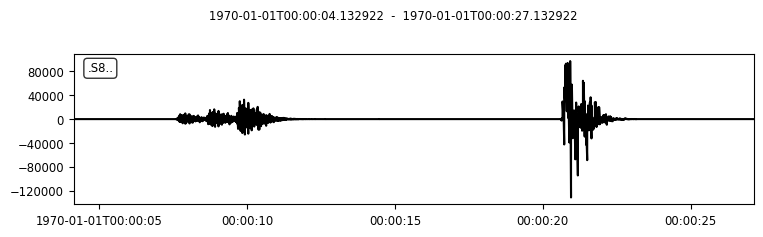

t0: 20.13292188708883
t1: 6.1329218870888305


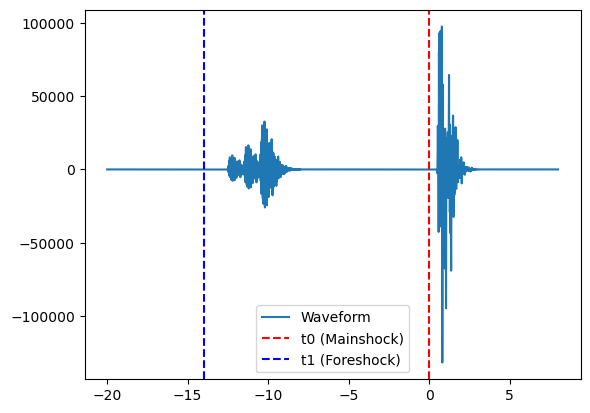

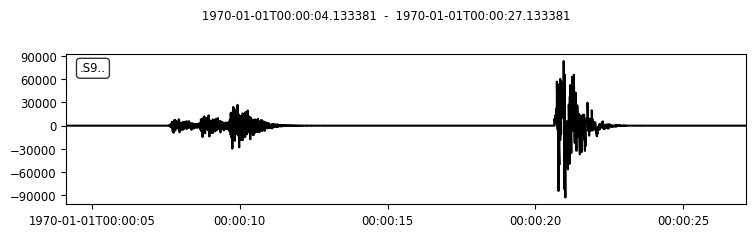

t0: 20.13338097809035
t1: 6.133380978090351


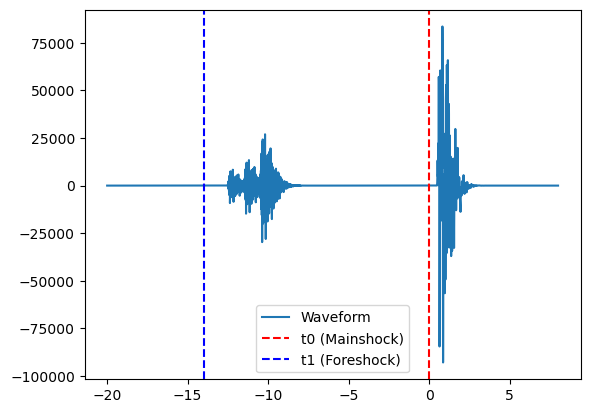

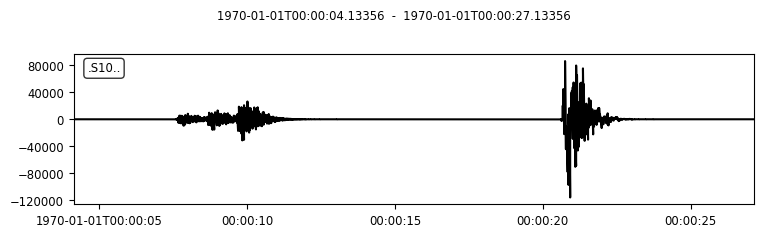

t0: 20.133559844550348
t1: 6.133559844550348


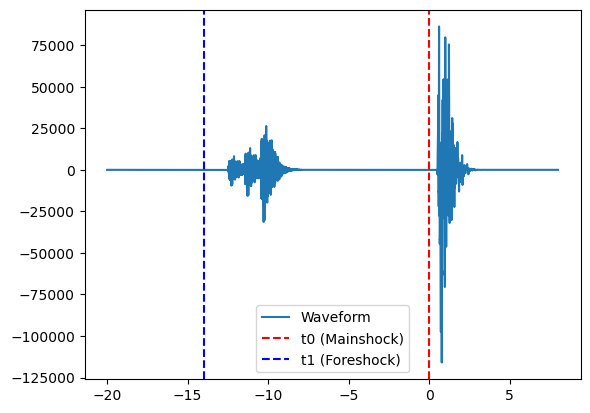

In [18]:
#plot each stations seismograms as python plot and matlab plot with t0 and t1 labelled
for trace in st1:
    # Define arrival time (absolute UTC time)'
    arrival_time = trace.stats.starttime + trace.stats.t0

    # Plot trace around arrival time
    trace.plot(starttime=arrival_time - 15, endtime=arrival_time + 8)

    # Define mainshock and foreshock times (relative)
    t0 = trace.stats.t0+1# Relative start of mainshock
    trace.stats.t1=t0-14
    t1 = trace.stats.t1  # Relative start of foreshock sequence

    print("t0:", t0)
    print("t1:", t1)

    # times2 is relative to `t0`
    times2 = trace.times() - t0  # Shift time axis to t0

    # Select the window around the event (-12 to 12 sec)
    ii = np.logical_and(times2 >= -20, times2 <= 8)

    # Plotting waveform and  lines
    plt.plot(times2[ii], trace.data[ii], label="Waveform")
    plt.axvline(0, color='r', linestyle='--', label="t0 (Mainshock)")
    plt.axvline(t1 - t0, color='b', linestyle='--', label="t1 (Foreshock)")  # Adjusted
    plt.legend()
    plt.show()

In [19]:
# compute the cross correlation
rad=np.array([100.])
xc=phscoh.calcxc(st1,st1,trange1=[0,4],trange2=[-14,-1],nsint1=1, nsint2=1, mk1='t0',mk2='t0',tpr='cosine')

# xc is an object which contains the cross spectra
print('The cross spectra have shape')
print(xc.xc.shape)

# and then calculate the moveout and coherence from the cross-spectra
xc.calcmvout()
xc.cpfromr()

xc.signalfraction()

The cross spectra have shape
(209715, 10, 1)


3.433227539054554


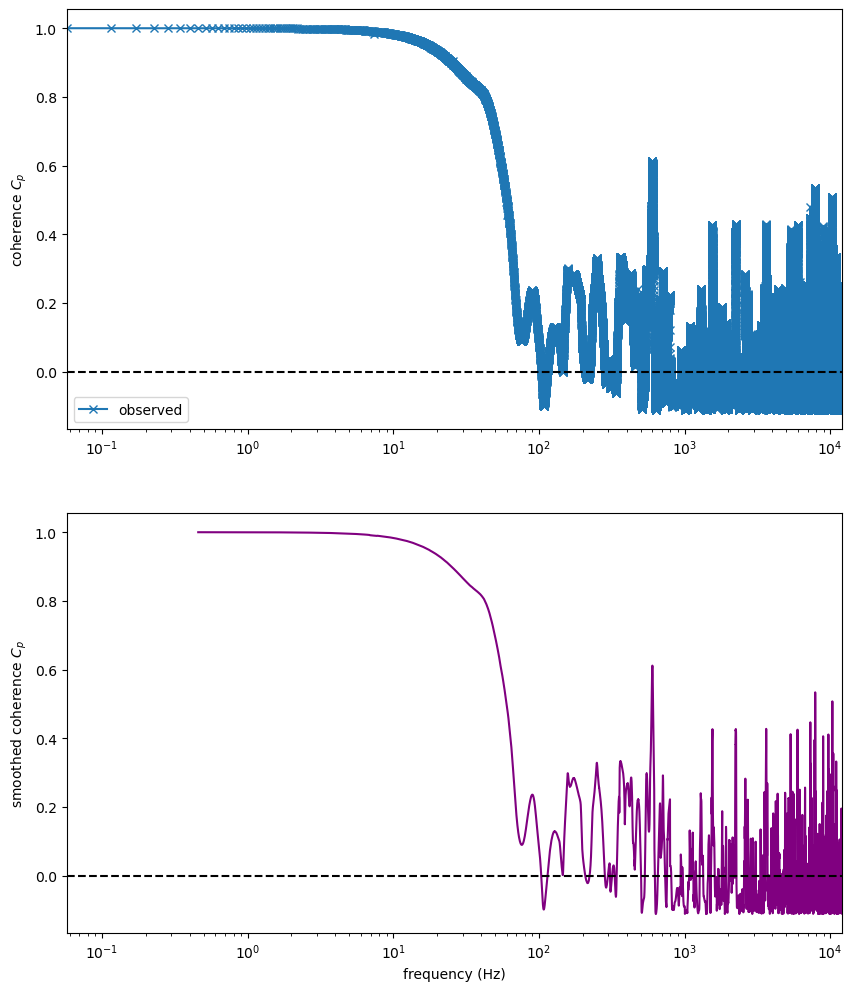

In [20]:
#plots coherence graph
window_size = 15
mean_values = np.array([np.mean(xc.Cp[k:k+window_size]) for k in range(len(xc.Cp) - window_size + 1)])
freq_mean = [np.mean(xc.freq[k:k+window_size]) for k in range(len(xc.freq) - window_size + 1)]

spacing = np.median(np.diff(xc.freq))
window_size_over_dfres=window_size*spacing/xc.dfres
print(window_size_over_dfres)
std_values = np.array([np.std(xc.Cp[k:k+window_size]) for k in range(len(xc.Cp) - window_size + 1)])/np.sqrt(window_size_over_dfres)

import matplotlib as matplotlib
y1=mean_values+std_values
y2=mean_values-std_values
y=np.append(y1,np.flipud(y2))
x=np.append(freq_mean,np.flipud(freq_mean))
xy=np.vstack([x,y]).T  #(Or maybe hstack, or without the transpose)

ply=matplotlib.patches.Polygon(xy,facecolor='pink',visible=True,zorder=0)

f= plt.figure(figsize=(10,12))
pr=plt.subplot(2,1,1)
pc=plt.subplot(2,1,2)

pr.plot(xc.freq,xc.Cp,label='observed',marker="x");
pr.set_ylabel('coherence $C_p$')
pr.legend(loc='lower left')

# Coherence plot
pc.plot(freq_mean, mean_values,color='purple', label='observed')
#pc.plot(xc.freq, np.random.rand(len(xc.freq)), label='with noise')  # Replace with xc.Cpn
pc.set_xlabel('frequency (Hz)')
pc.set_ylabel('smoothed coherence $C_p$')
pc.add_patch(ply)

# Apply log scale and limits
for ph in [pr, pc]:
    ph.set_xlim([xc.freq[0], xc.freq[-1]])
    ph.set_xscale('log')
    #ph.axvline(color='black', linestyle='--', label='expected')
    ph.axhline(0, color='black', linestyle='--')
plt.show()

In [21]:
#edit 100Hz to correct fall off to calculate spatial extent
0.7*6000/100

42.0